**Single cell sequencing** 

examines the sequence information from individual cells with optimized next-generation sequencing (NGS) technologies, providing a higher resolution of cellular differences and a better understanding of the function of an individual cell in the context of its microenvironment.
For example, in cancer, sequencing the DNA of individual cells can give information about mutations carried by small populations of cells.
In development, sequencing the RNAs expressed by individual cells can give insight into the existence and behavior of different cell types.
In microbial systems, a population of the same species can appear to be genetically clonal, but single-cell sequencing of RNA or epigenetic modifications can reveal cell-to-cell variability that may help populations rapidly adapt to survive in changing environments.

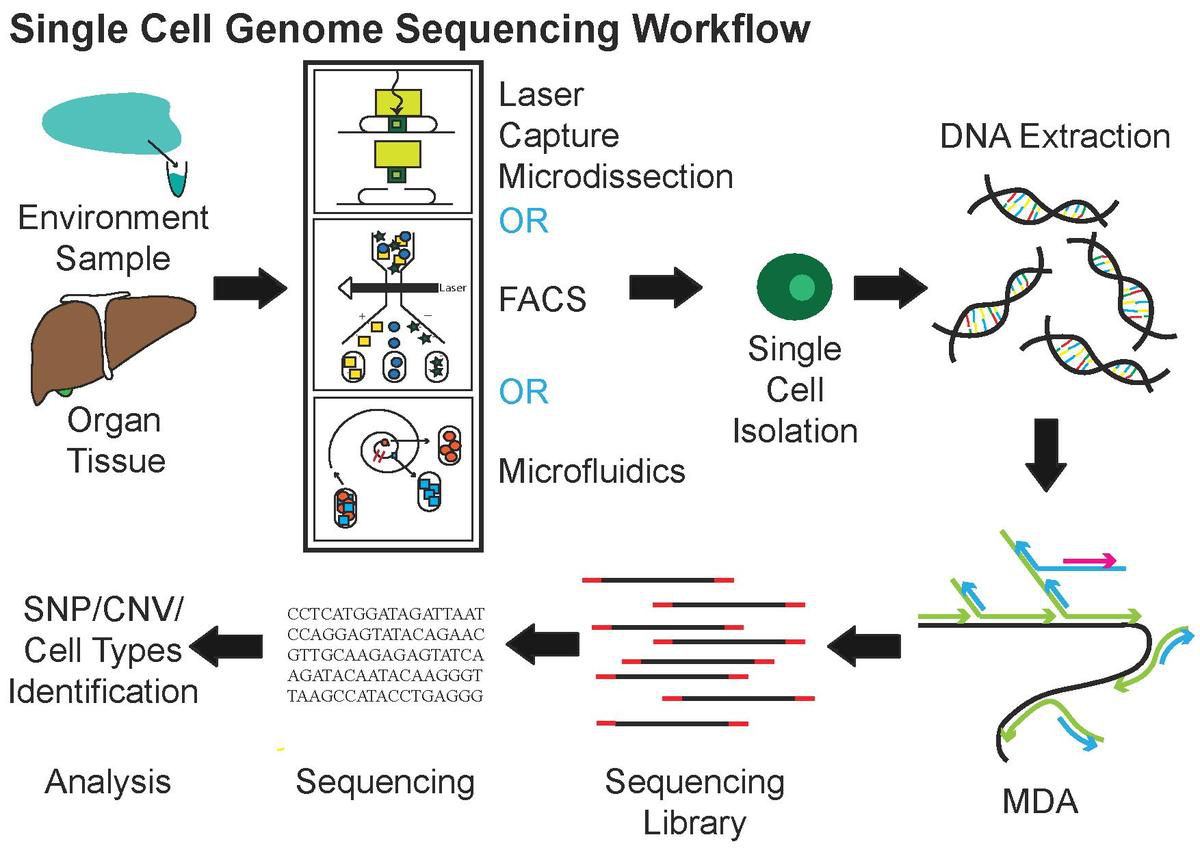

Overall, experimental scRNA-seq protocols are similar to the methods used for bulk RNA-seq.

Computational Analysis
This notebook is concerned with the computational analysis of the data obtained from scRNA-seq experiments and perform (quality control) QC we will be looking for cells which are outliers with respect to the rest of the dataset rather than comparing to independent quality standards.

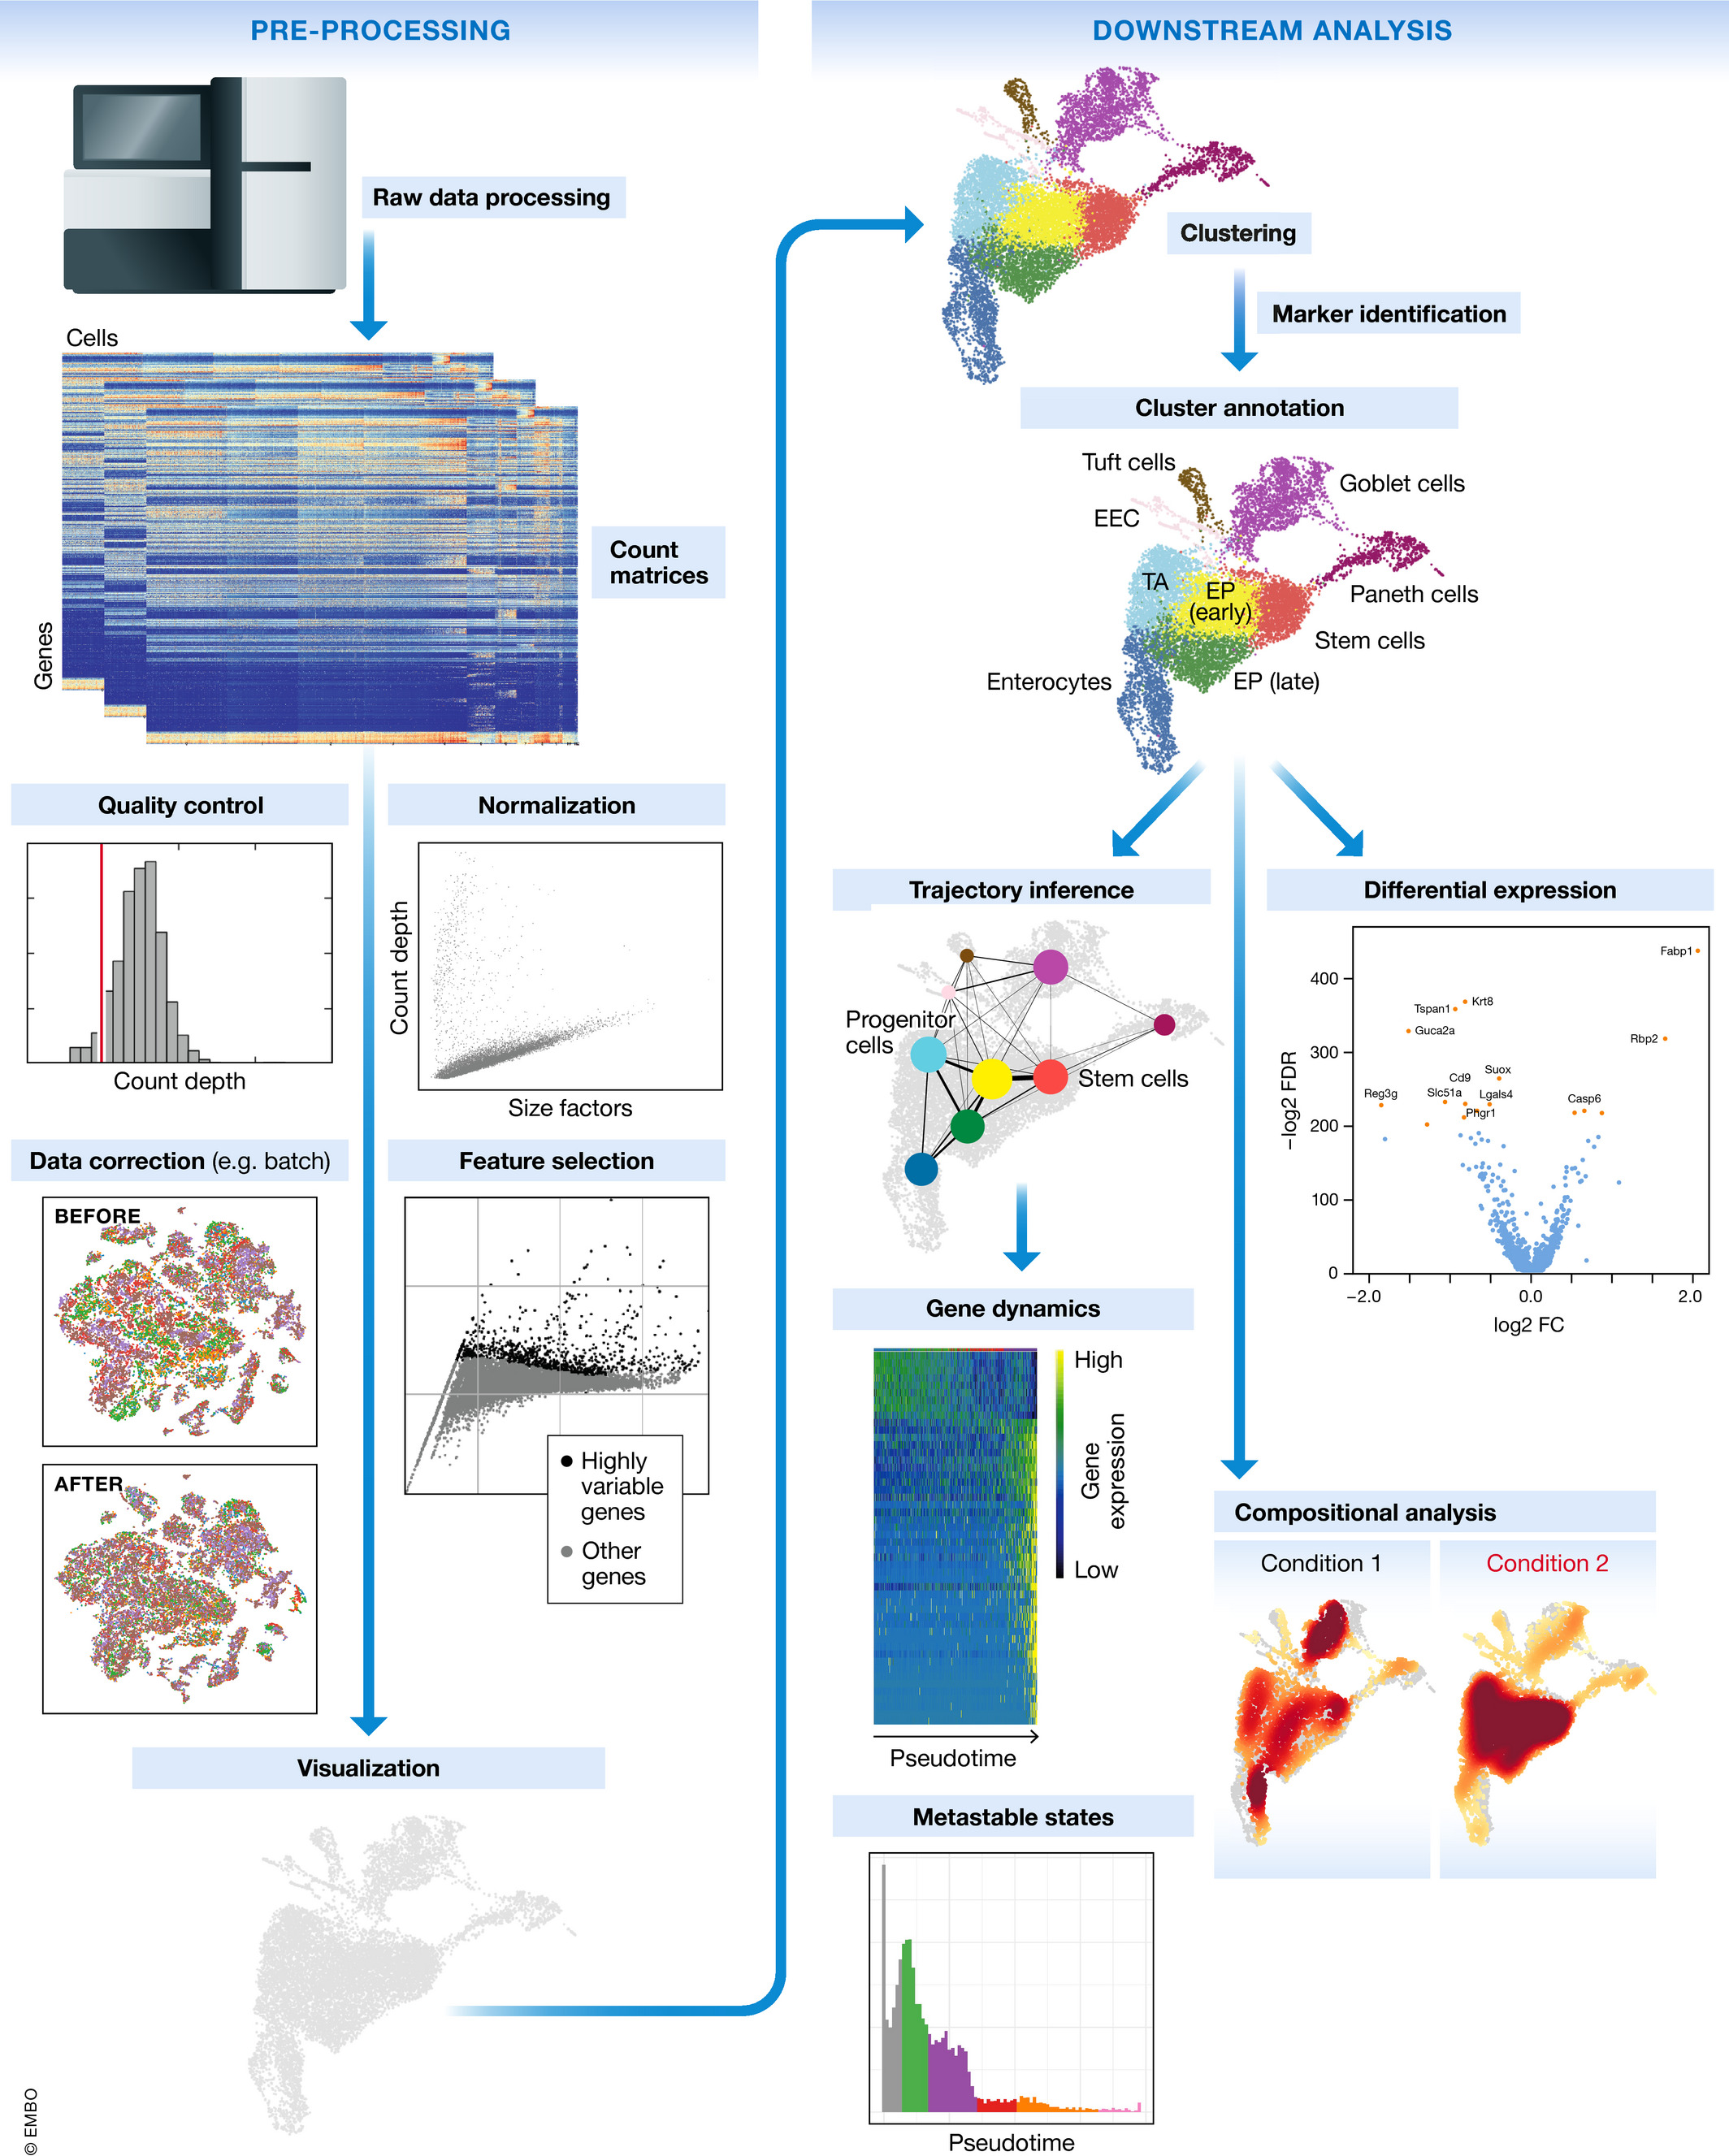

In this notebook i'll use:
Scanpy:import scanpy to handle our data

pandas:import pandas to handle dataframes

and matplotlib: import matplotlib to visualize our qc metrics

In [ ]:
!pip install -q scanpy

In [79]:
import numpy as np
import scanpy as sc
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline 
import warnings
warnings.filterwarnings("ignore")

Data preparing
Creating Anndata from the csv files in the dataset

What's Anndata?
AnnData stores observations (samples) of variables/features in the rows of a matrix.

Anndata : https://anndata.readthedocs.io/en/latest/

In [80]:

count_dataframe = pd.read_csv('brain_counts.csv', index_col=0) 
count_dataframe.head(2)

0610005C13Rik  0610007C21Rik  0610007L01Rik  \
A1.B003290.3_38_F.1.1              0            125             16   
A1.B003728.3_56_F.1.1              0              0              0   

                       0610007N19Rik  0610007P08Rik  0610007P14Rik  \
A1.B003290.3_38_F.1.1              0              0              0   
A1.B003728.3_56_F.1.1              0              0            324   

                       0610007P22Rik  0610008F07Rik  0610009B14Rik  \
A1.B003290.3_38_F.1.1              0              0              0   
A1.B003728.3_56_F.1.1              0              0              0   

                       0610009B22Rik  ...  Zxdb  Zxdc  Zyg11a  Zyg11b  Zyx  \
A1.B003290.3_38_F.1.1              0  ...     0     0       0       0    0   
A1.B003728.3_56_F.1.1              0  ...     0     0       0       0    0   

                       Zzef1  Zzz3  a  l7Rn6  zsGreen_transgene  
A1.B003290.3_38_F.1.1      0     0  0     54                  0  
A1.B003728.3_56_F.1.1      0     0  0      0                  0  

[2 rows x 23433 columns]

The column names represent genes. The row names represent unique cell identifiers


Brain Metadata
Metadata describes each cell.

In [81]:
metadata_dataframe = pd.read_csv('brain_metadata.csv', index_col=0)
print(metadata_dataframe.shape)
metadata_dataframe.head(2)

(3401, 5)


cell_ontology_class subtissue mouse.sex mouse.id  \
cell                                                                     
A1.B003290.3_38_F.1.1           astrocyte  Striatum         F   3_38_F   
A1.B003728.3_56_F.1.1           astrocyte  Striatum         F   3_56_F   

                      plate.barcode  
cell                                 
A1.B003290.3_38_F.1.1       B003290  
A1.B003728.3_56_F.1.1       B003728

In [82]:
print(pd.value_counts(metadata_dataframe['subtissue']))

Cortex         1149
Hippocampus     976
Striatum        723
Cerebellum      553
Name: subtissue, dtype: int64


As i use two dataframes, i need to Constructing AnnData using the two csv files

In [83]:
adata = sc.AnnData(X = count_dataframe, obs = metadata_dataframe)
print(adata.shape)

(3401, 23433)


**spike-in** labeling is designed to bind to a DNA molecule with a matching sequence by (hybridization)


In [84]:
is_spike_in = {}
number_of_spike_ins = 0

for gene_name in adata.var_names:
    if 'ERCC' in gene_name:
        is_spike_in[gene_name] = True 
        number_of_spike_ins += 1
    else:
        is_spike_in[gene_name] = False 
        
adata.var['ERCC'] = pd.Series(is_spike_in) 
print('found this many spike ins: ', number_of_spike_ins)

found this many spike ins:  92


In [85]:
adata.var.head()


ERCC
0610005C13Rik  False
0610007C21Rik  False
0610007L01Rik  False
0610007N19Rik  False
0610007P08Rik  False

Saving the AnnData objectfor later use and filteration 

In [86]:
adata.write('brain_raw.h5ad')

Quality and measurements filtring for cells and genes

First,compute quality measuers and filters then filter cells and genes accordingly.

In [87]:
adata.var.head()

ERCC
0610005C13Rik  False
0610007C21Rik  False
0610007L01Rik  False
0610007N19Rik  False
0610007P08Rik  False

calculate_qc_metrics when ['ERCC'] is inserted, it returns the information of both cells and genes with respect to Spike-ins.

In [88]:
qc = sc.pp.calculate_qc_metrics(adata, qc_vars = ['ERCC'])
                                 
                                
cell_qc_dataframe = qc[0]
gene_qc_dataframe = qc[1]

print('This is the cell quality control dataframe:')
cell_qc_dataframe.head()

This is the cell quality control dataframe:


n_genes_by_counts  log1p_n_genes_by_counts  \
cell                                                                  
A1.B003290.3_38_F.1.1                 3359                 8.119696   
A1.B003728.3_56_F.1.1                 1718                 7.449498   
A1.MAA000560.3_10_M.1.1               3910                 8.271548   
A1.MAA000564.3_10_M.1.1               4352                 8.378621   
A1.MAA000923.3_9_M.1.1                2248                 7.718241   

                         total_counts  log1p_total_counts  \
cell                                                        
A1.B003290.3_38_F.1.1        390075.0           12.874097   
A1.B003728.3_56_F.1.1        776439.0           13.562474   
A1.MAA000560.3_10_M.1.1     1616087.0           14.295519   
A1.MAA000564.3_10_M.1.1      360004.0           12.793873   
A1.MAA000923.3_9_M.1.1       290282.0           12.578611   

                         pct_counts_in_top_50_genes  \
cell                                                  
A1.B003290.3_38_F.1.1                     25.884766   
A1.B003728.3_56_F.1.1                     43.051933   
A1.MAA000560.3_10_M.1.1                   44.066006   
A1.MAA000564.3_10_M.1.1                   41.650926   
A1.MAA000923.3_9_M.1.1                    63.392494   

                         pct_counts_in_top_100_genes  \
cell                                                   
A1.B003290.3_38_F.1.1                      32.847017   
A1.B003728.3_56_F.1.1                      52.912721   
A1.MAA000560.3_10_M.1.1                    51.514553   
A1.MAA000564.3_10_M.1.1                    48.958623   
A1.MAA000923.3_9_M.1.1                     69.136908   

                         pct_counts_in_top_200_genes  \
cell                                                   
A1.B003290.3_38_F.1.1                      42.219573   
A1.B003728.3_56_F.1.1                      65.313309   
A1.MAA000560.3_10_M.1.1                    60.164211   
A1.MAA000564.3_10_M.1.1                    56.997422   
A1.MAA000923.3_9_M.1.1                     77.168753   

                         pct_counts_in_top_500_genes  total_counts_ERCC  \
cell                                                                      
A1.B003290.3_38_F.1.1                      59.472666            10201.0   
A1.B003728.3_56_F.1.1                      87.315423            67351.0   
A1.MAA000560.3_10_M.1.1                    74.451190            29870.0   
A1.MAA000564.3_10_M.1.1                    69.736170             2592.0   
A1.MAA000923.3_9_M.1.1                     90.522320            11002.0   

                         log1p_total_counts_ERCC  pct_counts_ERCC  
cell                                                               
A1.B003290.3_38_F.1.1                   9.230339         2.615138  
A1.B003728.3_56_F.1.1                  11.117688         8.674345  
A1.MAA000560.3_10_M.1.1                10.304644         1.848292  
A1.MAA000564.3_10_M.1.1                 7.860571         0.719992  
A1.MAA000923.3_9_M.1.1                  9.305923         3.790107

Dataframe details and notes:

“total_genes_by_counts”. Number of genes with positive counts in a cell. (total gene count having True ERCC)

“total_counts”. Total number of counts for a cell.

“pct_counts_in_top_50_genes”. Cumulative percentage of counts for 50 most expressed genes in a cell.

“total_counts_ercc”. Total number of counts for variabes in qc_vars.

“pct_counts_ercc”. Proportion of total counts for a cell which are ercc.

“total_counts”. Sum of counts for a gene.

“n_genes_by_counts”. The number of genes with at least 1 count in a cell. Calculated for all cells.

“mean_counts”. Mean expression over all cells.

“n_cells_by_counts”. Number of cells this expression is measured in.

“pct_dropout_by_counts”. Percentage of cells this feature does not appear in.

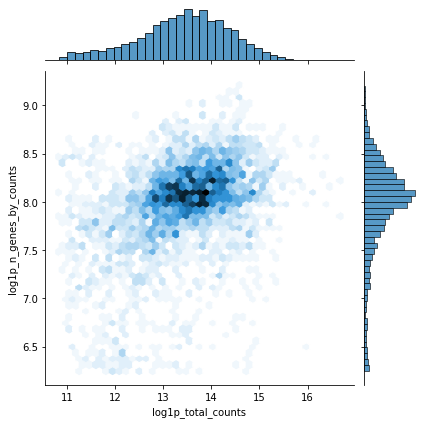

In [89]:
import seaborn as sns
sns.jointplot(
    data=cell_qc_dataframe,
    x="log1p_total_counts",
    y="log1p_n_genes_by_counts",
    kind="hex",
)

<AxesSubplot:xlabel='pct_counts_ERCC', ylabel='Count'>

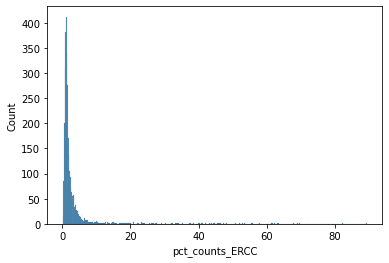

In [90]:
sns.histplot(cell_qc_dataframe["pct_counts_ERCC"])

Gives the histogram for pct_counts_ERCC - %genes in the cell which are ERCC

In [91]:
print('This is the gene quality control dataframe:')
gene_qc_dataframe.head()

This is the gene quality control dataframe:


n_cells_by_counts  mean_counts  log1p_mean_counts  \
0610005C13Rik                 28     0.118201           0.111721   
0610007C21Rik               2399   206.211990           5.333742   
0610007L01Rik                961    35.938549           3.609256   
0610007N19Rik                272     6.498383           2.014687   
0610007P08Rik                582    16.328728           2.852366   

               pct_dropout_by_counts  total_counts  log1p_total_counts  
0610005C13Rik              99.176713         402.0            5.998937  
0610007C21Rik              29.461923      701327.0           13.460731  
0610007L01Rik              71.743605      122227.0           11.713643  
0610007N19Rik              92.002352       22101.0           10.003424  
0610007P08Rik              82.887386       55534.0           10.924768

2nd, filtering the cells then genes accordingly.

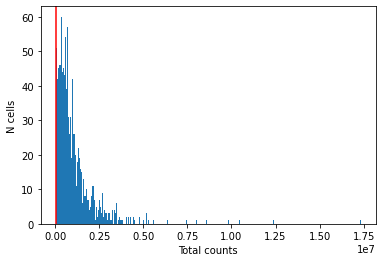

In [92]:
plt.hist(cell_qc_dataframe['total_counts'], bins=1000)
plt.xlabel('Total counts')
plt.ylabel('N cells')
plt.axvline(50000, color='red')

Reduce the noise by removing cells with fewer than 50,000 reads.

In [93]:
sum(cell_qc_dataframe['total_counts'] < 50000)

0

Genes detection

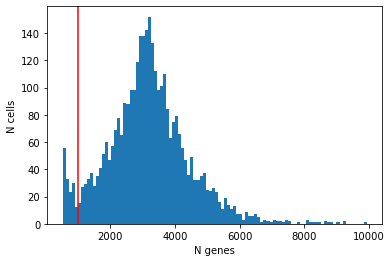

In [94]:
plt.hist(cell_qc_dataframe['n_genes_by_counts'], bins=100)
plt.xlabel('N genes')
plt.ylabel('N cells')
plt.axvline(1000, color='red')

Cells with a high level of spike-in RNAs had low starting amounts of RNA, likely due to the cell being dead or stressed which may result in the RNA being degraded.

Thus This ratio can be used to estimate the total amount of RNA in the captured cells.

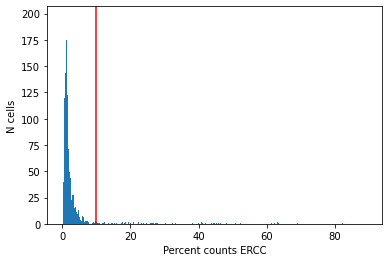

In [95]:
plt.hist(cell_qc_dataframe['pct_counts_ERCC'], bins=1000)
plt.xlabel('Percent counts ERCC')
plt.ylabel('N cells')
plt.axvline(10, color='red')

very high spike-in counts; these are likely dead cells and should be removed.

In [96]:
low_ERCC_mask = (cell_qc_dataframe['pct_counts_ERCC'] < 10)
adata = adata[low_ERCC_mask]

In [97]:
print('Started with: \n', adata)
sc.pp.filter_cells(adata, min_genes = 750)
print('Finished with: \n', adata)

Started with: 
 View of AnnData object with n_obs × n_vars = 3218 × 23433
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode'
    var: 'ERCC'
Finished with: 
 AnnData object with n_obs × n_vars = 3210 × 23433
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes'
    var: 'ERCC'


Genes Filtering , Genes with few cell count are outliers and should thus be removed.

In [98]:
gene_qc_dataframe.head()

n_cells_by_counts  mean_counts  log1p_mean_counts  \
0610005C13Rik                 28     0.118201           0.111721   
0610007C21Rik               2399   206.211990           5.333742   
0610007L01Rik                961    35.938549           3.609256   
0610007N19Rik                272     6.498383           2.014687   
0610007P08Rik                582    16.328728           2.852366   

               pct_dropout_by_counts  total_counts  log1p_total_counts  
0610005C13Rik              99.176713         402.0            5.998937  
0610007C21Rik              29.461923      701327.0           13.460731  
0610007L01Rik              71.743605      122227.0           11.713643  
0610007N19Rik              92.002352       22101.0           10.003424  
0610007P08Rik              82.887386       55534.0           10.924768

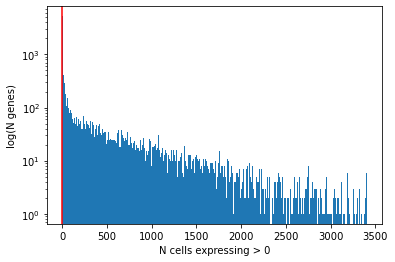

In [99]:
plt.hist(gene_qc_dataframe['n_cells_by_counts'], bins=1000)
plt.xlabel('N cells expressing > 0')
plt.ylabel('log(N genes)') # for visual clarity
plt.axvline(2, color='red')
plt.yscale('log') 

In [100]:
sum(gene_qc_dataframe['n_cells_by_counts'] < 2)

3969

There is 3969 genes which are having n_cells_by_counts < 2

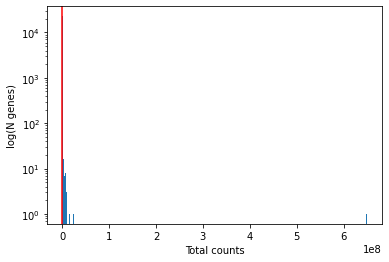

In [101]:
plt.hist(gene_qc_dataframe['total_counts'], bins=1000)
plt.xlabel('Total counts')
plt.ylabel('log(N genes)') # for visual clarity
plt.yscale('log') 
plt.axvline(10, color='red')

In [102]:
sum(gene_qc_dataframe['total_counts'] < 10)


4432

There are 4432 gene which is having sum_counts < 10

In [103]:
print('Started with: \n', adata)
sc.pp.filter_genes(adata, min_cells = 2)
sc.pp.filter_genes(adata, min_counts = 10)
print('Finished with: \n', adata)

Started with: 
 AnnData object with n_obs × n_vars = 3210 × 23433
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes'
    var: 'ERCC'
Finished with: 
 AnnData object with n_obs × n_vars = 3210 × 18585
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes'
    var: 'ERCC', 'n_cells', 'n_counts'


more genes filtering Around 5,000 genes are removed.

Saving the Quality Controlled adata

In [104]:
print(adata)
adata.write('brain_qc.h5ad')

AnnData object with n_obs × n_vars = 3210 × 18585
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes'
    var: 'ERCC', 'n_cells', 'n_counts'


In [105]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from matplotlib import pyplot as plt
%matplotlib inline

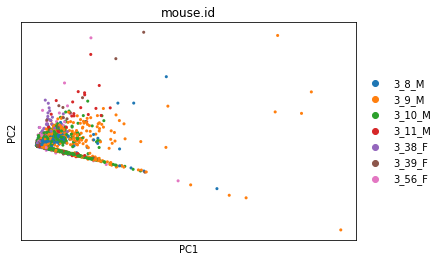

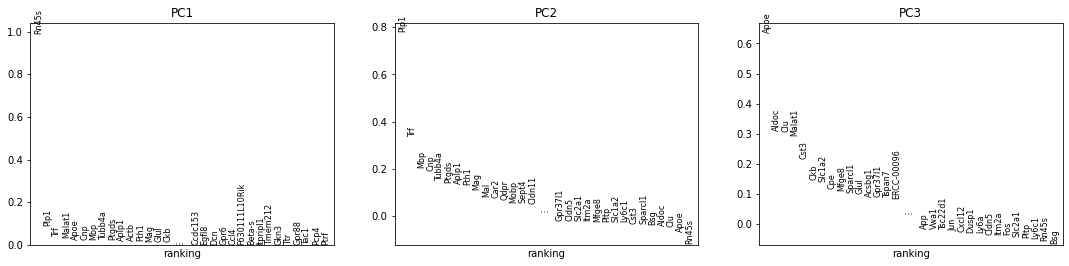

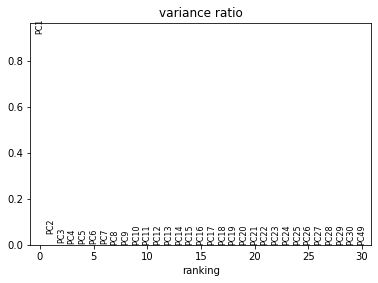

In [106]:
sc.pp.pca(adata)  # applies pca on adata and adds results of pca in adata in .obsm, .varm, .uns
sc.pl.pca_overview(adata, color='mouse.id')  # plot the pca results with color as mouse.id 

Normalizing cell library size

Major factor that contributes variation to single-cell RNA-sequencing experiments is "Library size variation". Library sizes vary for many reasons, including natural differences in cell size, variation of RNA capture, variation in the efficiency of PCR amplification used to generate enough RNA to create the sequencing library.

CPM

The simplest way to normalize this data is to convert it to counts per million (CPM) by dividing each row by a size factor (the sum of all counts in the row), then multiplying by 1,000,000. Note that this method assumes that each cell originally contained the same amount of RNA.

In [107]:
adata_cpm = adata.copy()  # apply this to a copy so I can compare methods
adata_cpm.raw = adata_cpm  # store a copy of the raw values before normalizing
sc.pp.normalize_per_cell(adata_cpm, 
                         counts_per_cell_after=1e6)
# Returns or updates adata with normalized version of the original adata_cpm.X

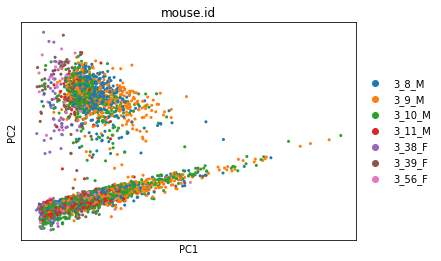

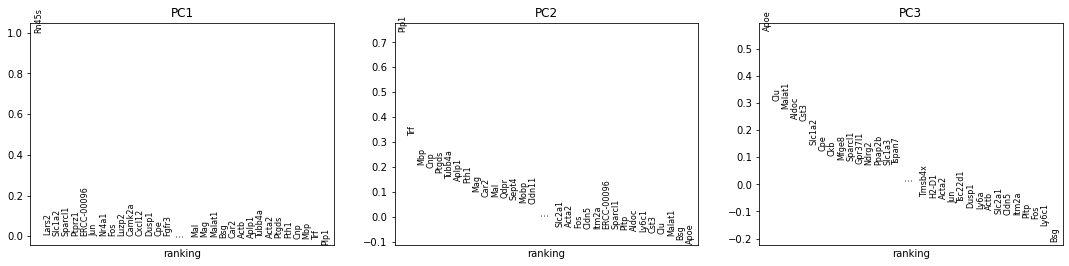

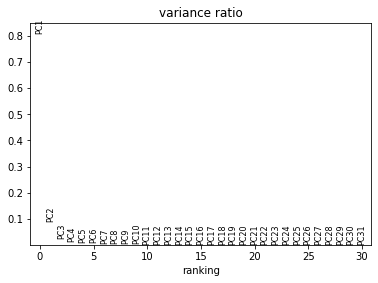

In [108]:
sc.pp.pca(adata_cpm)
sc.pl.pca_overview(adata_cpm, color='mouse.id')

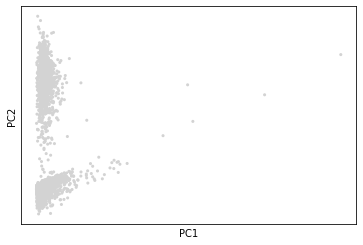

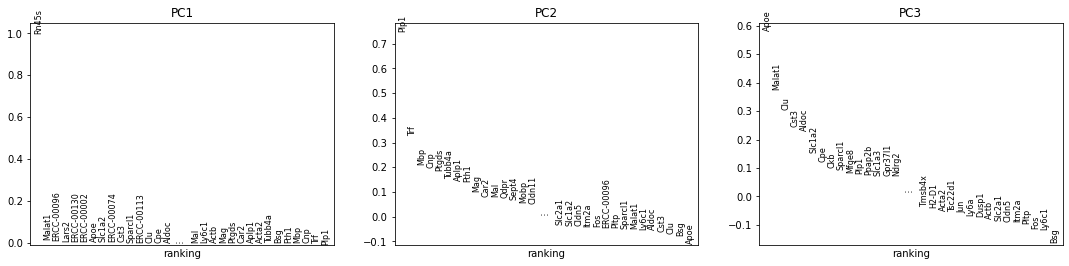

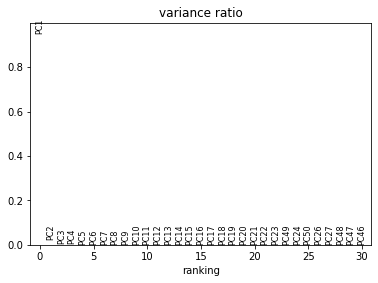

In [109]:
adata_cpm_ex = adata.copy() # make a copy so we can compare results
sc.pp.normalize_total(adata_cpm_ex, target_sum=1e6, exclude_highly_expressed=True) # normalize
sc.pp.pca(adata_cpm_ex) # run pca
sc.pl.pca_overview(adata_cpm_ex) # plot pca

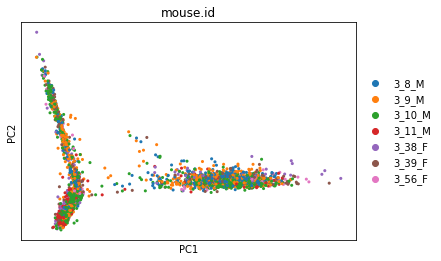

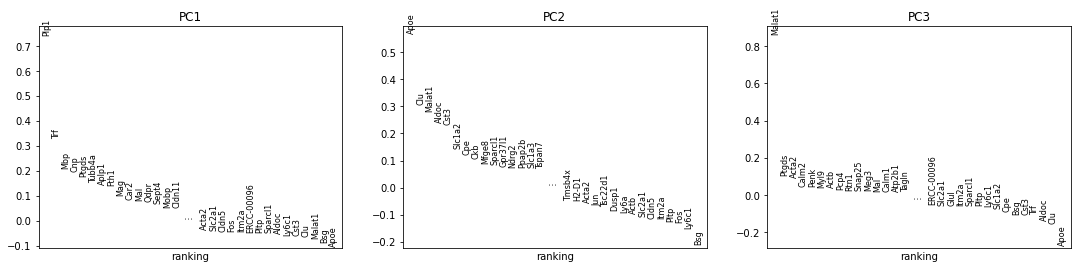

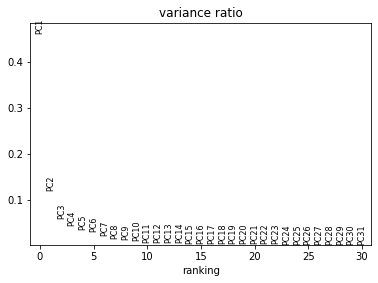

In [110]:
not_Rn45s = adata_cpm.var.index != 'Rn45s'
adata_no_Rn45s = adata_cpm[:, not_Rn45s]

sc.pp.pca(adata_no_Rn45s)
sc.pl.pca_overview(adata_no_Rn45s, color='mouse.id')

In [111]:
adata_no_Rn45s.shape, adata.shape

((3210, 18584), (3210, 18585))

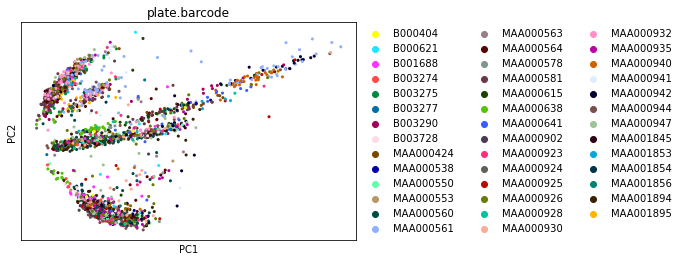

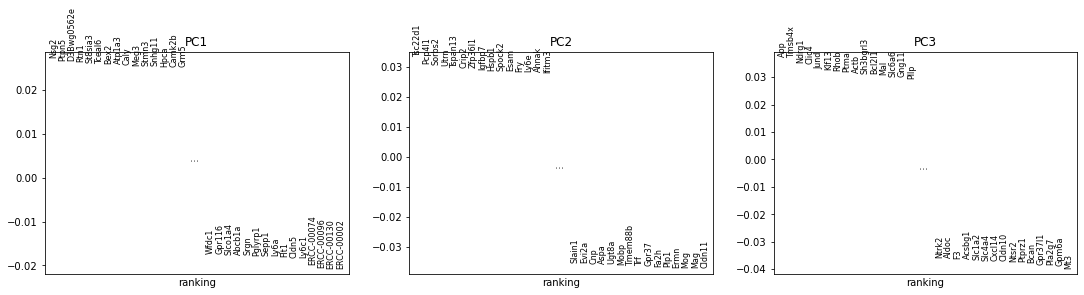

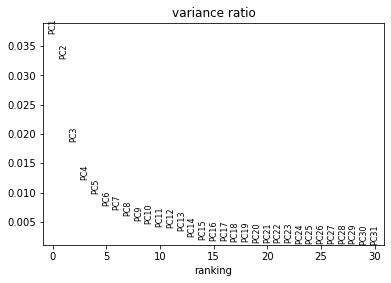

In [112]:
sc.pp.log1p(adata_cpm)  # Returns or updates data, depending on copy. X = log(X + 1) 
sc.pp.scale(adata_cpm)  # Scale data to unit variance and zero mean.
# updates adata with a scaled adata.X, annotated with 'mean' and 'std' in adata.var.
sc.pp.pca(adata_cpm)  
sc.pl.pca_overview(adata_cpm, color='plate.barcode')

In [113]:
adata_cpm.write('brain_normalized.h5ad')

In [114]:
adata = sc.read('brain_normalized.h5ad')

**tSNE**

tSNE (t-Distributed Stochastic Neighbor Embedding) combines dimensionality reduction (e.g. PCA) with random walks on the nearest-neighbour network to map high dimensional data (i.e. our 18,585 dimensional expression matrix) to a 2-dimensional space.

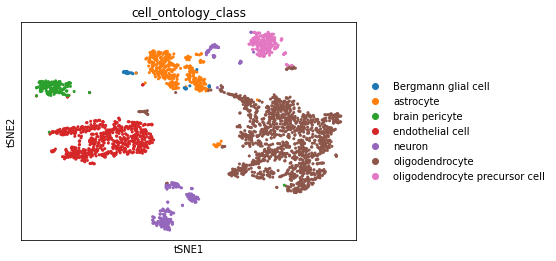

In [115]:
sc.tl.tsne(adata, perplexity=30, learning_rate=1000, random_state=0)  # add X_tsne in obsm

sc.pl.tsne(adata, color='cell_ontology_class')  # Plots using X_tsne which is tSNE coordinates of data.

Here, we see that tSNE generally does a good job of grouping similar cell types together (mixing with UMAP much better than tSBE alone), as there are still some neurons that are not grouped together.

UMAP

UMAP (Uniform Approximation and Projection) is a nonlinear dimensionality reduction method.

Now, applying UMAP on normalized data.

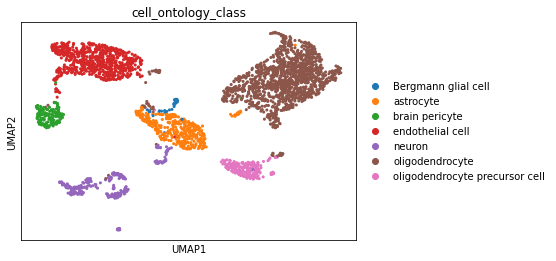

In [116]:
sc.pp.neighbors(adata) # UMAP is based on the neighbor graph; we'll compute this first

# Depending on copy, updates or returns adata with the following: connectivities and distances.
sc.tl.umap(adata, min_dist=0.5, spread=1.0, random_state=1, n_components=2)
sc.pl.umap(adata, color='cell_ontology_class')

Here, we see that UMAP generally does a a better job of grouping like cells together and achieving clean separation between cell types.

In [117]:
adata.write('brain_embeddings.h5ad')

UMAP

UMAP (Uniform Approximation and Projection) is a nonlinear dimensionality reduction method.


**clustering**

Grouping cells based on the similarity of their expression profiles allows us to identify cell types and states, as well as infer differences between groups. This is done either via clustering or community detection.

Some of the most popular approaches are hierarchical clustering and k-means clustering. These methods compute a distance metric between cells (often based on a low-dimensional representation, such as PCA, tSNE or UMAP), and then iteratively group cells together based on these distances.

Community detection methods (also referred to as 'graph-based clustering') partition the neighbor graph. The neighbor graph treats each cell as a node, with edges connecting each node to its k nearest neighbors (based on similar distance metrics described above). The graph is then partitioned into modules based on these connectivities. These methods are typically faster than other clustering methods with similar effectiveness.

**k-means - Applied on UMAP**

In k-means clustering, the goal is to partition N cells into k different clusters. This is done in an iterative manner, cluster centers are assigned and each cell is assigned to its nearest cluster:
Let's try this out on the umap representation of our dataset. Scanpy doesn't include a method for k-means clustering, so we'll extract the umap coordinates that we calculated earlier and use scikit-learn for this task instead.

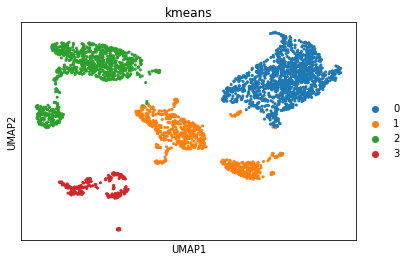

In [118]:
umap_coordinates = adata.obsm['X_umap'] # extract the UMAP coordinates for each cell
kmeans = KMeans(n_clusters=4, random_state=0).fit(umap_coordinates) # fix the random state for reproducibility

adata.obs['kmeans'] = kmeans.labels_ # retrieve the labels and add them as a metadata column in our AnnData object
adata.obs['kmeans'] = adata.obs['kmeans'].astype(str)

sc.pl.umap(adata, color='kmeans') # plot the results, Ploting the umap with the color as the cluster label

Evaluating clustering

Intuitively, we can see from the plot that our value of k (the number of clusters) is probably too low.
This dataset has "ground truth" cell type labels available (This might not be with every case) We can use these to assess our cluster labels a bit more rigorously using the adjusted Rand index.
This index is a measure between (0, 1) which indicates the similarity between two sets of categorical labels (e.g., our cell type labels and cluster labels). A value of 1 means the two clusterings are identical, and 0 means the level of similarity expected by random chance.

In [119]:
adata.obs['cell_ontology_class'].unique()

['astrocyte', 'oligodendrocyte', 'endothelial cell', 'neuron', 'oligodendrocyte precursor cell', 'Bergmann glial cell', 'brain pericyte']
Categories (7, object): ['Bergmann glial cell', 'astrocyte', 'brain pericyte', 'endothelial cell', 'neuron', 'oligodendrocyte', 'oligodendrocyte precursor cell']

In [120]:
rand_index = adjusted_rand_score(labels_true = adata.obs['cell_ontology_class'], labels_pred = adata.obs['kmeans'])
print('The Rand index is', round(rand_index, 2))

The Rand index is 0.82


**The Rand Index**

computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.
The adjusted Rand index is thus ensured to have a value close to 0.0 for random labeling independently of the number of clusters and samples and exactly 1.0 when the clusterings are identical (up to a permutation).
Higher the score, better the clustering

Graph-based methods

Graph-based methods attempt to partition a pre-computed neighhbor graph into modules (i.e., groups / clusters of cells) based on their connectivity.
Currently, the most widely used graph-based methods for single cell data are variants of the **louvain** algorithm. The intuition behind the louvain algorithm is that it looks for areas of the

In [121]:
!pip install louvain

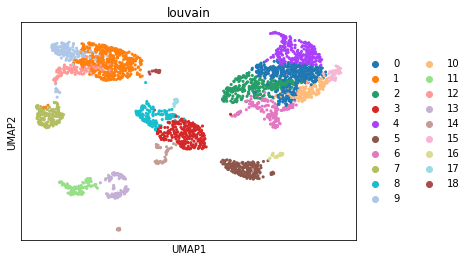

In [122]:
from scanpy.tl import louvain
louvain(adata)  # Cluster cells into subgroups # adata.obs['louvain']
sc.pl.umap(adata, color='louvain')

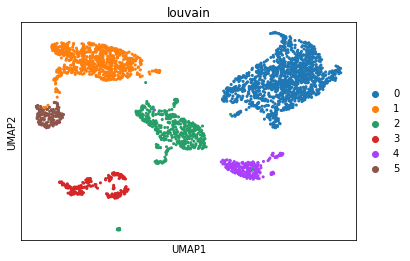

The rand index is  0.91


In [123]:
louvain(adata, resolution = 0.1)  # Cluster cells into subgroups # adata.obs['louvain']
sc.pl.umap(adata, color='louvain')

rand_index = adjusted_rand_score(adata.obs['cell_ontology_class'], adata.obs['louvain'])
print('The rand index is ', round(rand_index, 2))

We can use it Sometimes, we may want to look at clusters within a given tissue or cell type designation. This can surface interesting heterogeneity between subpopulations, although it can also make our results more noisy.for example
Looking into the cells having Cerebellum subtissue.

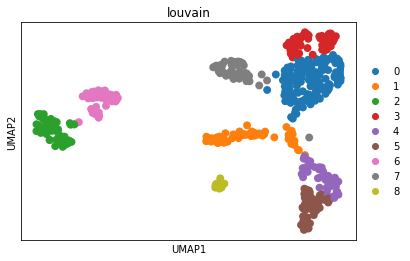

In [124]:
cerebellum = adata[adata.obs['subtissue'] == 'Cerebellum']
sc.pp.neighbors(cerebellum)
sc.tl.umap(cerebellum)

sc.tl.louvain(cerebellum)
sc.pl.umap(cerebellum, color='louvain')

In [125]:
sc.tl.louvain(adata, resolution=0.1)
adata.write('brain_clusters.h5ad')

Now that we've assigned cells into clusters, we'd like to understand what makes each cluster different from other cells in the dataset, or to annotate clusters according to their cell types (as has been previously done for this dataset).

There are several approaches to this task:

Look for upregulation of marker genes for cell types of interest (compared to the rest of the dataset)
**Compare** the complete gene expression profiles between groups
Use **automated** methods to compare cells of interest to databases of cell type expression profiles to combine clustering and annotation
Automated methods are a promising advance, but are not yet able to replace careful human curation.


**For well-defined cell types, we expect marker genes to show large differences in expression between the cell type of interest and the rest of the dataset, allowing to use simple methods. i'll focus on this approach.**

In [126]:
adata

AnnData object with n_obs × n_vars = 3210 × 18585
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes', 'n_counts', 'kmeans', 'louvain'
    var: 'ERCC', 'n_cells', 'n_counts', 'mean', 'std'
    uns: 'log1p', 'mouse.id_colors', 'pca', 'plate.barcode_colors', 'tsne', 'cell_ontology_class_colors', 'neighbors', 'umap', 'kmeans_colors', 'louvain', 'louvain_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [127]:
#adata = sc.read('/content/brain_clusters.h5ad')
#raw = sc.read('/content/brain_raw.h5ad')

raw = pd.DataFrame(data=adata.raw.X, index=adata.raw.obs_names, columns=adata.raw.var_names)

In [128]:
adata

AnnData object with n_obs × n_vars = 3210 × 18585
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes', 'n_counts', 'kmeans', 'louvain'
    var: 'ERCC', 'n_cells', 'n_counts', 'mean', 'std'
    uns: 'log1p', 'mouse.id_colors', 'pca', 'plate.barcode_colors', 'tsne', 'cell_ontology_class_colors', 'neighbors', 'umap', 'kmeans_colors', 'louvain', 'louvain_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

Load Data
For differential expression, we need to use the raw values stored in adata.raw.

With differential expression, we want to account for both the center and spread of the expression in each group. Recall that when we normalized our values, we standardized the distribution of each gene across cells to be centered at 0 and scaled with variance 1. So, when calculating differential expression, we should use the raw values (post-QC, pre-normalization). We saved these in adata.raw earlier on.

In [129]:
print(raw.shape)
raw.head()

(3210, 18585)


0610005C13Rik  0610007C21Rik  0610007L01Rik  \
cell                                                                   
A1.B003290.3_38_F.1.1              0.0          125.0           16.0   
A1.B003728.3_56_F.1.1              0.0            0.0            0.0   
A1.MAA000560.3_10_M.1.1            0.0          348.0            0.0   
A1.MAA000564.3_10_M.1.1            0.0           41.0           36.0   
A1.MAA000923.3_9_M.1.1             0.0           53.0            0.0   

                         0610007N19Rik  0610007P08Rik  0610007P14Rik  \
cell                                                                   
A1.B003290.3_38_F.1.1              0.0            0.0            0.0   
A1.B003728.3_56_F.1.1              0.0            0.0          324.0   
A1.MAA000560.3_10_M.1.1            0.0            0.0            5.0   
A1.MAA000564.3_10_M.1.1            0.0            0.0           24.0   
A1.MAA000923.3_9_M.1.1             0.0            0.0            0.0   

                         0610007P22Rik  0610009B14Rik  0610009B22Rik  \
cell                                                                   
A1.B003290.3_38_F.1.1              0.0            0.0            0.0   
A1.B003728.3_56_F.1.1              0.0            0.0            0.0   
A1.MAA000560.3_10_M.1.1            0.0            0.0            0.0   
A1.MAA000564.3_10_M.1.1            0.0            0.0           14.0   
A1.MAA000923.3_9_M.1.1             0.0            0.0            0.0   

                         0610009D07Rik  ...  Zwint  Zxda  Zxdb  Zxdc  Zyg11b  \
cell                                    ...                                    
A1.B003290.3_38_F.1.1              0.0  ...    0.0   0.0   0.0   0.0     0.0   
A1.B003728.3_56_F.1.1              0.0  ...    0.0   0.0   0.0   0.0     0.0   
A1.MAA000560.3_10_M.1.1          316.0  ...  266.0   0.0   0.0   0.0     0.0   
A1.MAA000564.3_10_M.1.1            0.0  ...    0.0   0.0   0.0   0.0     0.0   
A1.MAA000923.3_9_M.1.1             0.0  ...    0.0   0.0   0.0   0.0    81.0   

                           Zyx  Zzef1  Zzz3    a  l7Rn6  
cell                                                     
A1.B003290.3_38_F.1.1      0.0    0.0   0.0  0.0   54.0  
A1.B003728.3_56_F.1.1      0.0    0.0   0.0  0.0    0.0  
A1.MAA000560.3_10_M.1.1    0.0  195.0   0.0  0.0  113.0  
A1.MAA000564.3_10_M.1.1  125.0    0.0   1.0  0.0    0.0  
A1.MAA000923.3_9_M.1.1     0.0    0.0   0.0  0.0    0.0  

[5 rows x 18585 columns]

**Comparing distributions**

Differential expression algorithms represent various approaches to comparing the distribution of gene expression in one group versus another group.
Unlike bulk RNA-seq, we generally have a large number of samples (i.e. cells) for each group we are comparing in single-cell experiments.
Thus, we can take advantage of the whole distribution of expression values in each group to identify differences between groups rather than only comparing estimates of mean-expression as is standard for bulk RNASeq..

Building intuition

In this example, we have a cluster of interest, and we want to determine if they are astrocytes. Let's start by plotting the distibution of a marker gene's expression in the cluster compared to the rest of the dataset.

In [130]:
adata.obs.cell_ontology_class.unique()

['astrocyte', 'oligodendrocyte', 'endothelial cell', 'neuron', 'oligodendrocyte precursor cell', 'Bergmann glial cell', 'brain pericyte']
Categories (7, object): ['Bergmann glial cell', 'astrocyte', 'brain pericyte', 'endothelial cell', 'neuron', 'oligodendrocyte', 'oligodendrocyte precursor cell']

In [131]:
astrocyte_marker = 'Gja1' # define genes of interest
cluster2 = raw[adata.obs['louvain'] == '2'] # Use a mask to subset dataset to cells assigned to cluster 2
not_cluster2 = raw[adata.obs['louvain'] != '2'] # All other cells

In [132]:
cluster2.head()  # Dataframe containing cells belonging to cluster 2

0610005C13Rik  0610007C21Rik  0610007L01Rik  \
cell                                                                   
A1.B003290.3_38_F.1.1              0.0          125.0           16.0   
A1.B003728.3_56_F.1.1              0.0            0.0            0.0   
A1.MAA000923.3_9_M.1.1             0.0           53.0            0.0   
A1.MAA000930.3_8_M.1.1             0.0            0.0            0.0   
A10.MAA000926.3_9_M.1.1            0.0          136.0            0.0   

                         0610007N19Rik  0610007P08Rik  0610007P14Rik  \
cell                                                                   
A1.B003290.3_38_F.1.1              0.0            0.0            0.0   
A1.B003728.3_56_F.1.1              0.0            0.0          324.0   
A1.MAA000923.3_9_M.1.1             0.0            0.0            0.0   
A1.MAA000930.3_8_M.1.1             0.0            0.0            0.0   
A10.MAA000926.3_9_M.1.1            0.0            0.0            0.0   

                         0610007P22Rik  0610009B14Rik  0610009B22Rik  \
cell                                                                   
A1.B003290.3_38_F.1.1              0.0            0.0            0.0   
A1.B003728.3_56_F.1.1              0.0            0.0            0.0   
A1.MAA000923.3_9_M.1.1             0.0            0.0            0.0   
A1.MAA000930.3_8_M.1.1             0.0            0.0            0.0   
A10.MAA000926.3_9_M.1.1            8.0            0.0            0.0   

                         0610009D07Rik  ...  Zwint  Zxda  Zxdb  Zxdc  Zyg11b  \
cell                                    ...                                    
A1.B003290.3_38_F.1.1              0.0  ...    0.0   0.0   0.0   0.0     0.0   
A1.B003728.3_56_F.1.1              0.0  ...    0.0   0.0   0.0   0.0     0.0   
A1.MAA000923.3_9_M.1.1             0.0  ...    0.0   0.0   0.0   0.0    81.0   
A1.MAA000930.3_8_M.1.1           587.0  ...    0.0   0.0   0.0   0.0     3.0   
A10.MAA000926.3_9_M.1.1            0.0  ...    0.0   0.0   0.0   0.0     0.0   

                         Zyx  Zzef1   Zzz3    a  l7Rn6  
cell                                                    
A1.B003290.3_38_F.1.1    0.0    0.0    0.0  0.0   54.0  
A1.B003728.3_56_F.1.1    0.0    0.0    0.0  0.0    0.0  
A1.MAA000923.3_9_M.1.1   0.0    0.0    0.0  0.0    0.0  
A1.MAA000930.3_8_M.1.1   0.0    0.0    0.0  0.0    0.0  
A10.MAA000926.3_9_M.1.1  0.0   76.0  181.0  0.0  129.0  

[5 rows x 18585 columns]

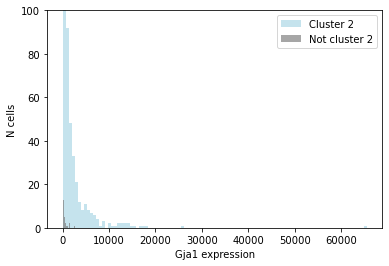

In [133]:
cluster2_marker_exp = cluster2[astrocyte_marker]  # getting the values for all cells of cluster 2 for the specific gene
plt.hist(cluster2_marker_exp.values, bins=100, color='lightblue', alpha=0.7, label='Cluster 2') # Plot distribution

not_cluster2_marker_exp = not_cluster2[astrocyte_marker]  # # getting the values for all cells not belonging to cluster 2 for the specific gene
plt.hist(not_cluster2_marker_exp, bins=100, color='gray', alpha=0.7, label='Not cluster 2')

plt.ylim(0,100) # Cut off at N=100 for visual clarity
plt.xlabel('%s expression'%astrocyte_marker) # label our axes
plt.ylabel('N cells')
plt.legend()

Just by eyeballing the two distributions we can see that:

Cells in this cluster express more of the marker gene than other cells in the dataset.
However, we also see that these distributions overlap: some cells in the cluster don't express the gene at all, and some cells outside the cluster express it relatively highly.

**So, how do we decide whether this cluster is actually "differentially expressing" our marker gene?**

Because we expect the differences in expression to be relatively large for marker genes, we can use straightforward hypothesis testing methods to ask for the probability (p-value) that we would observe this level of differential expression if all these cells were, in fact, the same population (i.e., if the null hypothesis were true).

**T-test**
Suppose we observe two independent samples, e.g. flower petal lengths, and we are considering whether the two samples were drawn from the same population (e.g. the same species of flower or two species with similar petal characteristics) or two different populations.

The t-test quantifies the difference between the arithmetic means of the two samples. The **p-value** quantifies the probability of observing as or more extreme values assuming the null hypothesis, that the samples are drawn from populations with the same population means, is true.

In [134]:
from scipy.stats import ttest_ind

ttest = ttest_ind(cluster2_marker_exp, 
          not_cluster2_marker_exp, 
          equal_var=False, # it's not necessarily fair to assume that these two populations have equal variance
          nan_policy='omit') # omit NaN values
print(ttest)

Ttest_indResult(statistic=10.472000376695075, pvalue=2.3204030965250666e-23)


This result tells you that we would be very surprised if these two populations had no true difference in mean expression, given the observed sample.

**Working with the whole dataset**

Scanpy has a very useful function for repeating this process of subsetting the dataset to one group and comparing it to the rest of the dataset.

It then returns the genes that are most differentially expressed between that group and all others. Let's look at the genes that are most cell-type specific.


Computing differential expression vai using "cell_ontology_class

In [140]:
sc.pp.log1p(adata)

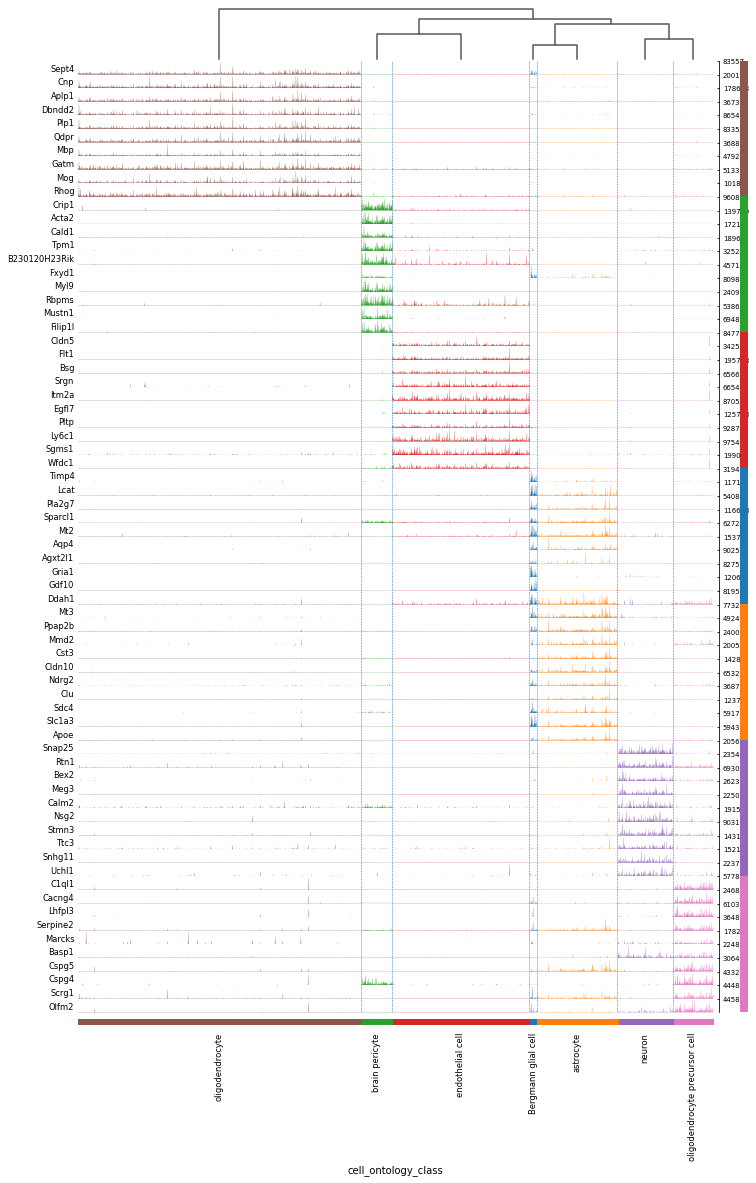

In [141]:
# Rank genes for characterizing groups
sc.tl.rank_genes_groups(adata, groupby='cell_ontology_class', use_raw=True, method='t-test_overestim_var', n_genes=10) # compute differential expression
# The key of the observations grouping to consider.-> "cell_ontology_class"
sc.pl.rank_genes_groups_tracksplot(adata, groupby='cell_ontology_class')  # Plot ranking of genes using heatmap plot (

In [144]:
#Computing differential expression vai using "louvain" clusters

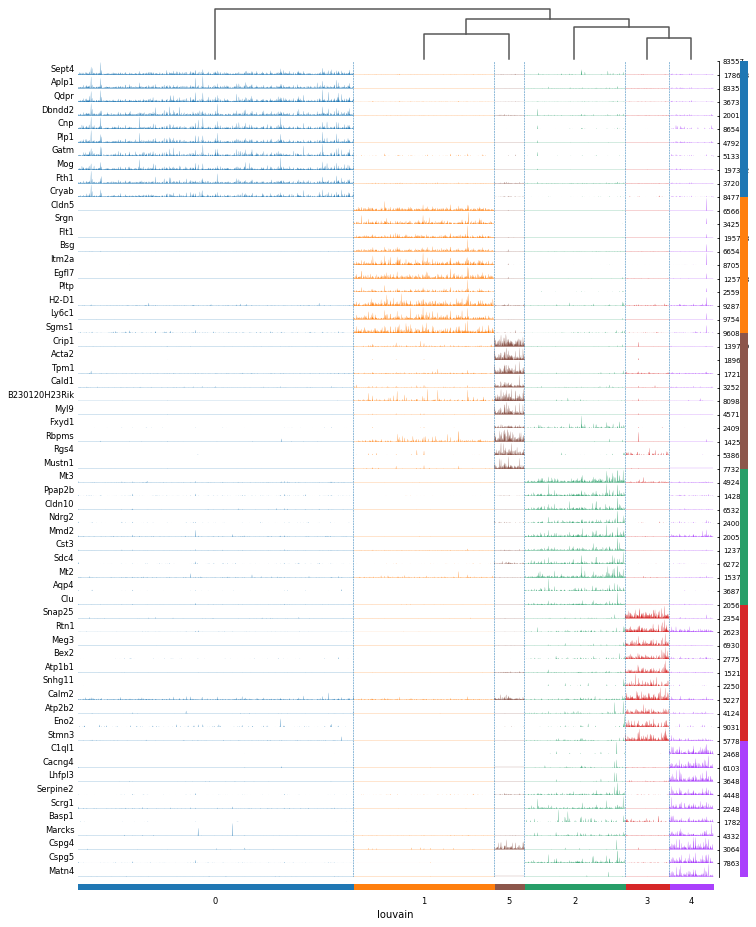

In [143]:
sc.tl.rank_genes_groups(adata, groupby='louvain', use_raw=True, 
                        method='t-test_overestim_var', n_genes=10) # compute differential expression
sc.pl.rank_genes_groups_tracksplot(adata, groupby='louvain') # Plot ranking of genes using heatmap plot (

Comparing to "known" marker genes

We can also compare these data-driven marker genes to those considered by the field to be classic indicators of cell type.

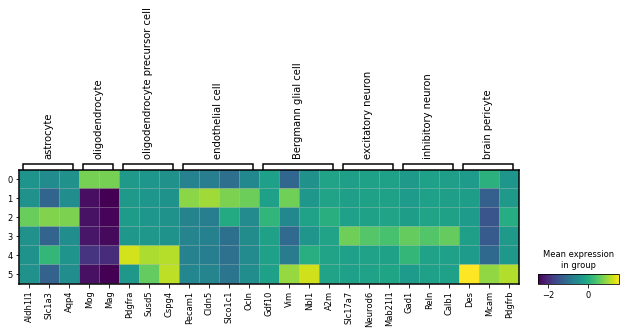

In [142]:
marker_genes = {
'astrocyte': ['Aldh1l1', 'Slc1a3', 'Aqp4'], 
'oligodendrocyte': ['Mog','Mag'],
'oligodendrocyte precursor cell': ['Pdgfra','Susd5','Cspg4'],
'endothelial cell': ['Pecam1','Cldn5','Slco1c1','Ocln'],
'Bergmann glial cell': ['Gdf10','Vim','Nbl1','A2m'],
'excitatory neuron': ['Slc17a7','Neurod6','Mab21l1'],
'inhibitory neuron': ['Gad1','Reln','Calb1'],
'brain pericyte': ['Des','Mcam','Pdgfrb']
}

sc.pl.matrixplot(adata, marker_genes, groupby='louvain', use_raw=False)